# House Prices Dataset Analysis - *Given information about a house, predict its price*

Last updated: September 2020

## How is this useful?



## About the Dataset



The data is open source and can be viewed/downloaded from https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## Part 1: Dataset Exploration

In [298]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# read in the dataset, print shape and column titles
train_set = pd.read_csv('train.csv')
print("Training set shape: ", train_set.shape)

Training set shape:  (1460, 81)


In [299]:
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

#numerical = train_set.select_dtypes(include=numerics)
#print(numerical.shape)

New shape:  (1460, 26)


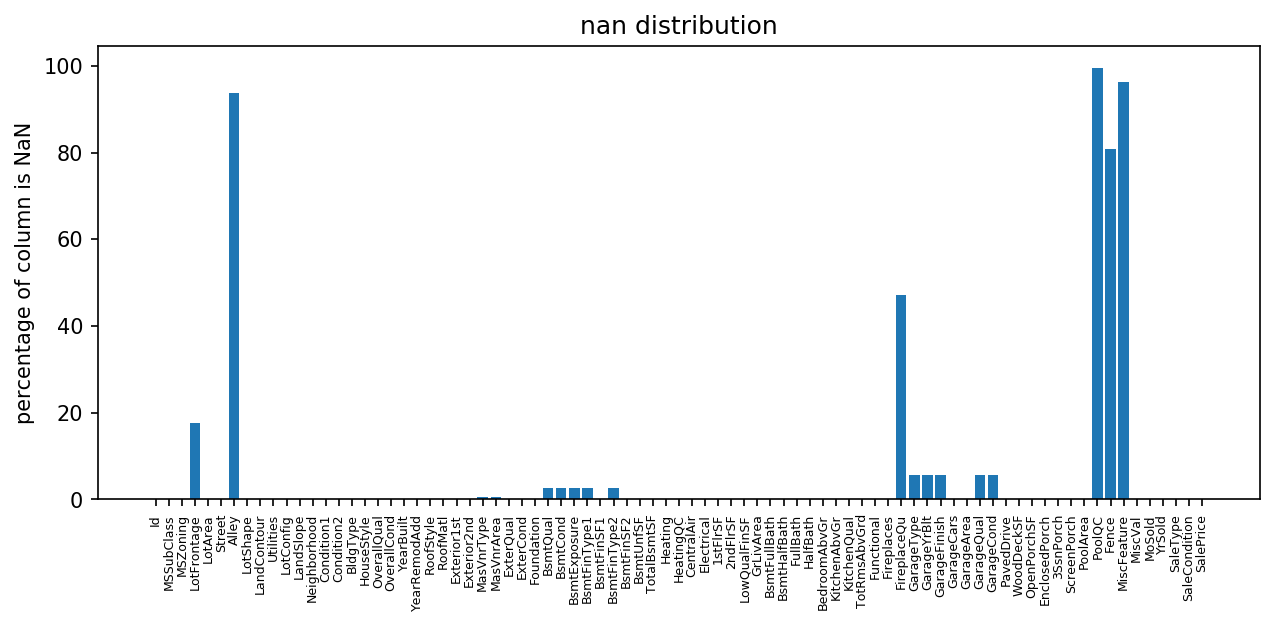

In [309]:
# count number of NaN values in the columns
nans = []
all_nans = train_set.isna().sum()

for i in range(len(all_nans)):
    nans.append((all_nans[i]/1460)*100)

# plot the number of NaN values per column
plt.figure(dpi=150,figsize=(10,4))
plt.bar(list(train_set.columns), nans)
plt.xticks([i for i in range(len(list(train_set.columns)))], list(train_set.columns), rotation='vertical', fontsize=6)
plt.title('nan distribution')
plt.ylabel('percentage of column is NaN')

print("New shape: ", numerical.shape)

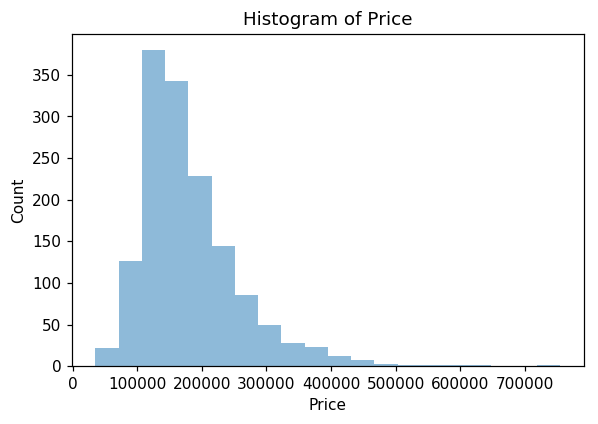

In [292]:
saleprice = numerical.iloc[:,-1].values

plt.figure(dpi=110)
plt.hist(saleprice,20,alpha=0.5)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Histogram of Price')
plt.show()

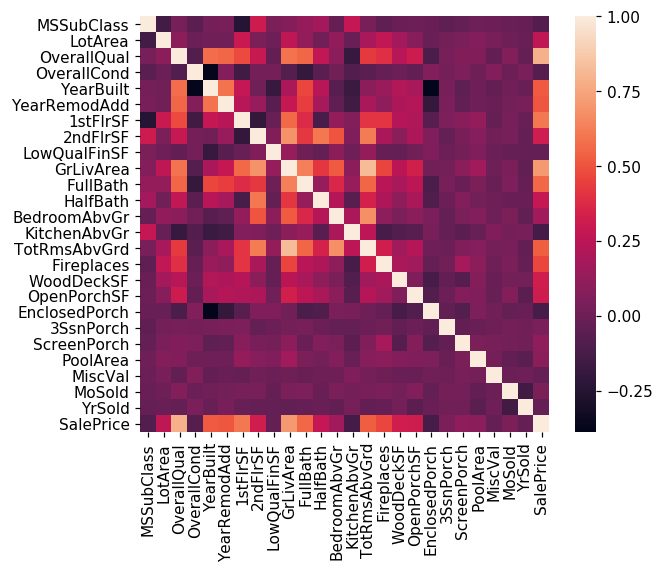

In [294]:
from sklearn.feature_selection import VarianceThreshold
import seaborn as sn

correlated_features = set()
correlation_matrix = numerical.corr()

plt.figure(dpi=110,figsize=(6,5))
sn.heatmap(correlation_matrix, annot=False)
plt.show()

In [282]:
poor_features = []

for i in range(26):
    if correlation_matrix.iloc[-1,i] < 0.4:
        poor_features.append(correlation_matrix.columns[i])
    
print(poor_features)
print(len(poor_features))

numerical.drop(labels=poor_features, axis=1, inplace=True)

['MSSubClass', 'LotArea', 'OverallCond', '2ndFlrSF', 'LowQualFinSF', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
17


In [283]:
X_train = numerical.iloc[:,:-1].values
y_train = numerical.iloc[:,-1].values

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X_train)
y = sc_y.fit_transform(y_train.reshape(-1,1))

/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [284]:
# fitting XGboost to the training set
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

(1459, 8)


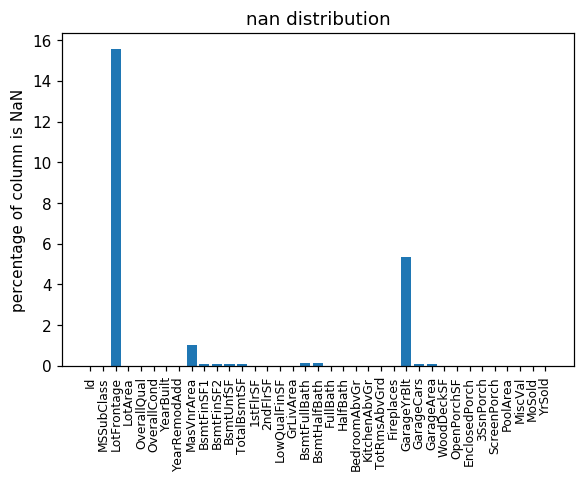

In [285]:
test_set = pd.read_csv('test.csv')

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

test_numerical = test_set.select_dtypes(include=numerics)

# count number of NaN values in the columns
nans = []
all_nans = test_numerical.isna().sum()

for i in range(len(all_nans)):
    nans.append((all_nans[i]/1460)*100)

# plot the number of NaN values per column
plt.figure(dpi=110)
plt.bar(list(test_numerical.columns), nans)
plt.xticks([i for i in range(len(list(test_numerical.columns)))], list(test_numerical.columns), rotation='vertical', fontsize=8)
plt.title('nan distribution')
plt.ylabel('percentage of column is NaN')

test_numerical = test_numerical.drop(columns=['Id','LotFrontage', 'MasVnrArea', 
                                              'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                                              'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 
                                              'GarageArea', 'MSSubClass', 'LotArea', 'OverallCond', '2ndFlrSF', 
                                              'LowQualFinSF', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                                              'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                                              'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'])

print(test_numerical.shape)

[115095.   135753.11 175352.25 ... 138874.66 120050.8  232563.1 ]


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


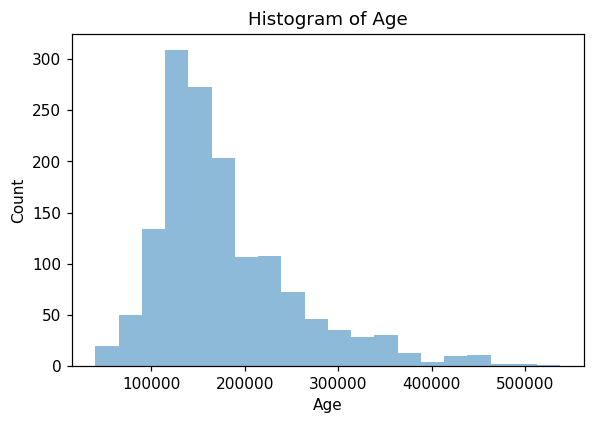

In [286]:
X_test = test_numerical.iloc[:,:].values

y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_test)))

print(y_pred)

plt.figure(dpi=110)
plt.hist(y_pred,20,alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age')
plt.show()

In [287]:
ids = list(test_set.iloc[:,0].values)

predictions = pd.DataFrame(y_pred,index=ids)
predictions.rename(columns={ predictions.columns[0]: "SalePrice" }, inplace = True)
predictions = predictions.rename_axis("Id")

predictions.to_csv('predictons.csv')